# Residual Network
Introduced by He et al. in [Deep Residual Learning for Image Recognition](https://paperswithcode.com/paper/deep-residual-learning-for-image-recognition)

The paper argues that deeper neural networks are more difficult to train but deep networks naturally integrate low/mid/highlevel features  and classifiers in an end-to-end multilayer fashion, and the “levels” of features can be enriched by the number of stacked layers (depth). And thus, should perform at least as well as shallower models because the extra layers can just learn to perform an identity mapping.

**Side Note**: Formula for dimension after Convolution
* $m$ = Orignal dimension
* $p$ = Padding
* $k$ = Kernel size
* $s$ = Stride
* $m'$ = New dimension

$ m' = \frac{m + 2p - k}{s} + 1$

# Residual Learning
Formally, denoting the desired underlying mapping as $H(x)$
, we let the stacked nonlinear layers fit another mapping of $F(x) = H(x) - x$ 
. The original mapping is recast into $H(x) = F(x) + x$
.

In this case, learning identity mapping for $H(x)$ is equivalent to learning $F(x)$ to be $0$, which is easier to learn. And thus at the very least the network will perform as well as a network without this **residual block**.

There is empirical evidence that these types of network are easier to optimize, and can gain accuracy from considerably increased depth.

In the parameterized form this can be written as,

$F(x,{W_i
​
 })+x$

and when the feature map sizes of $F(x,W_i)$ and $x$ are different the paper suggests doing a **linear projection**, with learned weights $W_s$​.

$F(x,{W_i})+W_sx$

The paper also experimented with *zero padding* but found that *linear projection* worked better. Also when the feature map sizes match they found *identity mapping* to be better than *linear projections*.

$F$ should have more than one layer, otherwise the sum $F(x,{W_i})+W_sx$ also won't have non-linearities and will be like a linear layer.

In [1]:
import torch
from torch import nn

# Linear Projections for Shortcut Connection
This does the $W_sx$ projection described above. The projection shortcut in Eqn is used to match dimensions (done by 1×1 convolutions).

Inputs for the `Module`:
* `in_channels` :  is the number of channels in $x$
* `out_channels` : is the number of channels in $F(x,{W_i})$
* `stride` : is the stride length in the convolution operation for $F$. We do the same stride on the shortcut connection, to match the feature-map size.

In [2]:
class LinearProjection(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride) #Convolution layer for linear projection W_s.x
        # New dimension = (m-k)/s +1 = (m-1)/s +1 
        self.bn = nn.BatchNorm2d(out_channels)  # Paper suggests adding batch normalization after each convolution operation

    def forward(self, x: torch.Tensor):
        return self.bn(self.conv(x))

# Residual Block
Residual Blocks are **skip-connection** blocks that learn residual functions with reference to the layer inputs, instead of learning unreferenced functions. They were introduced as part of the ResNet architecture.

The intuition is that it is *easier to optimize* the residual mapping than to optimize the original, unreferenced mapping. To the extreme, if an identity mapping
$H(x) = x$
were optimal, it would be easier to push the residual
$F(x)$
to zero than to fit an identity mapping by a stack of nonlinear layers. 
>Having skip connections allows the network to more easily learn identity-like mappings than a stack of nonlinear layers

<img src="https://production-media.paperswithcode.com/methods/resnet-e1548261477164_2_mD02h5A.png" alt="Residual Block" width="300" height="230">

## Implementing the Residual Block

The first convolution layer maps from `in_channels` to `out_channels` , where the `out_channels` is higher than `in_channels` when we reduce the feature map size with a stride length greater than 1.

The second convolution layer maps from `out_channels` to `out_channels` and always has a stride length of 1.

Both convolution layers are followed by batch normalization.

* `in_channels` : is the number of channels in x
* `out_channels` : is the number of output channels
* `stride` : is the stride length in the convolution operation.

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1) 
        # New Dim = (m+2-3)/s +1 = (m-1)/s +1 = m'
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1) # same effect (on dimensions) as k=1 and p=0, ie Linear projection
        # New Dim = (m' +2 -3)/1 +1 = m' = (m-1)/s +1
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Check for if the dimensions are matching else need to project
        if stride != 1 or in_channels != out_channels:
            self.shortcut = LinearProjection(in_channels, out_channels, stride) 
            # (m -1)/s +1 = m'
        else:
            self.shortcut = nn.Identity()
        
        self.activation2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        skip_con = self.shortcut(x)

        x = self.activation1(self.bn1(self.conv1(x)))

        x = self.bn2(self.conv2(x)) + skip_con

        return self.activation2(x)

# Bottleneck Residual Block
>The use of a bottleneck reduces the number of parameters and matrix multiplications
A Bottleneck Residual Block is a variant of the [**residual block**](#residual-block) that utilises *1x1 convolutions* to create a bottleneck. The use of a bottleneck reduces the number of parameters and matrix multiplications. The idea is to make residual blocks as thin as possible to increase depth and have less parameters. They were introduced as part of the ResNet architecture, and are used as part of deeper ResNets such as ResNet-50 and ResNet-101.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-07_at_2.12.02_PM.png" alt="Bottleneck Residual Block" width="240" height="400">

## Implementation
It has 1×1, 3×3, and 1×1 convolution layers.

The first convolution layer maps from `in_channels` to `bottleneck_channels` with a 1×1 convolution, where the `bottleneck_channels` is lower than `in_channels`.

The second 3×3 convolution layer maps from `bottleneck_channels` to `bottleneck_channels` . This can have a stride length greater than 1 when we want to compress the feature map size.

The third, final 1×1 convolution layer maps to `out_channels`. `out_channels` is higher than `in_channels` if the stride length is greater than 1; otherwise, `out_channels` is equal to `in_channels`.

`bottleneck_channels` is less than `in_channels` and the 3×3 convolution is performed on this shrunk space (hence the bottleneck). The two 1×1 convolution decreases and increases the number of channels.

Inputs:
* `in_channels` : is the number of channels in $x$.
* `bottleneck_channels` : is the number of channels for the 3×3 convlution
* `out_channels` : is the number of output channels
* `stride` : is the stride length in the 3×3 convolution operation.

In [4]:
class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels: int, bottleneck_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=bottleneck_channels, kernel_size=1, stride=1)
        # m' = m
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.activation1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=bottleneck_channels, out_channels=bottleneck_channels, kernel_size=3, stride=stride, padding=1)
        # m'' = (m-1)/s +1
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.activation2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=bottleneck_channels, out_channels=out_channels, kernel_size=1, stride=1)
        # m' = m
        self.bn3 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.skip = LinearProjection(in_channels=in_channels, out_channels=out_channels, stride=stride)
        else:
            self.skip = nn.Identity()

        self.activation3 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        skip = self.skip(x)

        x = self.activation1(self.bn1(self.conv1(x)))

        x = self.activation2(self.bn2(self.conv2(x)))

        x = self.activation3( self.bn3(self.conv3(x)) + skip )

        return x

# ResNet Model
This is a the base of the resnet model without the final linear layer and softmax for classification.

The resnet is made of stacked [residual blocks](#residual-block) or [bottleneck residual blocks](#bottleneck-residual-block). The feature map size is halved after a few blocks with a block of stride length 2. The number of channels is increased when the feature map size is reduced. Finally the feature map is average pooled to get a vector representation.

Inputs:
* `n_blocks` : is a list of of number of blocks for each feature map size.
* `n_channels` : is the number of channels for each feature map size.
* `bottlenecks` : is the number of channels the bottlenecks. If this is None , residual blocks are used.
* `img_channels` : is the number of channels in the input.
* `first_kernel_size` : is the kernel size of the initial convolution layer

In [5]:
from typing import List, Optional
class ResNet(nn.Module):

    def __init__(self, n_blocks: List[int] = [3, 3, 3], 
                 n_channels:  List[int] = [16, 32, 64], 
                 bottlenecks: Optional[List[int]] = None, # It is optional to have bottleneck blocks
                 img_channels: int = 3, # By default 3
                 first_kernel_size: int = 7 # As used in the paper
                 ):
        super().__init__()

        assert len(n_blocks) == len(n_channels)     # Number of blocks and number of channels for each feature map size
        
        # If bottleneck residual blocks are used, the number of channels in bottlenecks should be provided for each feature map size
        assert bottlenecks is None or len(bottlenecks) == len(n_channels)

        self.conv1st = nn.Conv2d(img_channels, n_channels[0], kernel_size=first_kernel_size, stride=2, padding=first_kernel_size // 2)
        self.bn = nn.BatchNorm2d(n_channels[0])

        blocks = []

        prev_channels = n_channels[0]

        for i, channels in enumerate(n_channels):
            # The first block for the new feature map size, will have a stride length of 2 except for the very first block
            stride = 1 if len(blocks) == 0 else 2   

            if bottlenecks is None:
                blocks.append(ResidualBlock(in_channels=prev_channels, out_channels=channels, stride=stride))
            else:
                blocks.append(BottleneckResidualBlock(in_channels=prev_channels, bottleneck_channels=bottlenecks[i], out_channels=channels, stride=stride))

            for _ in range(n_blocks[i] - 1):
                if bottlenecks is None:
                    blocks.append(ResidualBlock(in_channels=channels, out_channels=channels, stride=1))
                else:
                    blocks.append(BottleneckResidualBlock(in_channels=channels, bottleneck_channels=bottlenecks[i], out_channels=channels, stride=1))

            prev_channels = channels
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor):
        
        x = self.bn(self.conv1st(x))

        x = self.blocks(x)

        return x

# Training
As a running example we'll use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for training. But I'll try to write a more general purpose function.

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
x, y = trainset[1]
x.shape, y

(torch.Size([3, 32, 32]), 9)

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

file = '/root/Work/PaperImplementation/ResNet/data/cifar-10-batches-py/data_batch_1'
bat1 = unpickle(file)
keys = list(bat1.keys())
keys

[b'batch_label', b'labels', b'data', b'filenames']

In [10]:
bat1[keys[2]].shape

(10000, 3072)

Loaded in this way, each of the batch files contains a dictionary with the following elements:

* `data` -- a $10000x3072$ numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* `labels` -- a list of $10000$ numbers in the range 0-9. The number at index $i$ indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

* `label_names` -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, `label_names[0] == "airplane"`, `label_names[1] == "automobile"`, etc.


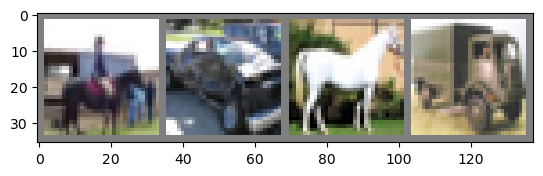

horse car   horse truck


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.153
[1,  4000] loss: 1.834
[1,  6000] loss: 1.667
[1,  8000] loss: 1.574
[1, 10000] loss: 1.511
[1, 12000] loss: 1.487
Finished Training


In [15]:
x, y = trainset[5]
x.unsqueeze_(0)
net.eval()
out = net(x)
out.shape, classes[torch.argmax(out)], classes[y]

(torch.Size([1, 10]), 'car', 'car')

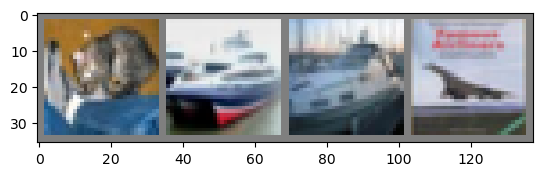

GroundTruth:  cat   ship  ship  plane


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [17]:
outputs = net(images)

In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  bird  car   car   plane


In [19]:
class classifier(nn.Module):
    def __init__(self, base: nn.Module, input_shape: tuple, n_classes: int):
        super().__init__()
        
        self.base = base
        # Figuring out the size of the outputs
        input = torch.randn(input_shape)
        base_out = base(input.unsqueeze(0))
        in_linear = nn.Flatten()(base_out)
        in_linear = in_linear.shape[1]

        self.bn = nn.BatchNorm2d(base_out.shape[1])
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=in_linear, out_features=int(2**n_classes))
        self.fc2 = nn.Linear(in_features=int(2**n_classes), out_features=int(2**n_classes/4))
        self.fc3 = nn.Linear(in_features=int(2**n_classes/4), out_features=n_classes)
        self.act = nn.ReLU()
        self.drop = nn.Dropout()


    def forward(self, x):
        x = self.base(x)
        x = self.bn(x)
        x = self.flat(x)
        x = self.drop(x)

        x = self.act(self.fc1(x))
        x = self.drop(x)

        x = self.act(self.fc2(x))
        x = self.drop(x)
        
        x = self.fc3(x)
        x = torch.nn.functional.softmax(x)
        return x


In [20]:
base = ResNet()
net = classifier(base, (3, 32, 32), 10)
net

classifier(
  (base): ResNet(
    (conv1st): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation1): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Identity()
        (activation2): ReLU()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation1): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=